In [74]:
import os
import sys
import pandas as pd
import numpy as np
import warnings

from scipy.stats import betabinom

from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


import gc

root_path = root_path = os.path.realpath('../..')
try:
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from auto_causality import AutoCausality
from auto_causality.data_utils import CausalityDataset

from flaml import AutoML
import wise_pizza as wp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CausalTune for AB Testing 

CausalTune can be used for AB Testing in two ways:
1. Variance Reduction
2. Segmentation analysis

#### 1. Variance Reduction
A standard variance reduction technique is to control for natural variation in the experiment's outcome metric. The simplest way to do so is by running a simple regression with a selection of controls. A potentially more powerful and automated approach is to run CausalTune. 

#### 2. Segmentation Analysis

We use the heterogeneous treatment effect estimates from CausalTune to feed them into the segmentation analytics tool Wise-Pizza.

### Data Generating Process

The DGP in this example can be described as follows:

\begin{align}
    & T \sim Bernoulli(.5)\\
    %T &= h(\beta \cdot W) + \eta \\ 
    Y &= T* \rho + m(\gamma \cdot X) + \epsilon \\
    &\rho = 0.01 \\
    %& W \sim BetaBinom(8, 600, 400) \\ % later give individual probabilities
    %\beta & = (.1, .2, .3, .4, .5, 0 , 0, ...)\\
    & X \sim hypergeometric(5, 5, 8)\\
    & \gamma \sim Uniform([.5, 1.5]) \\
    & m(x) = .5*x

\end{align}
In particular, we assume 
- perfect randomisation of the treatment as we are replicating an AB test environment and
- a constant treatment effect (for now).

In [76]:

def generate_synth_data_with_categories(
    n_samples=10000,
    n_x=10,
) -> CausalityDataset:
    n_w = 3
    T = np.random.binomial(1, 0.5, size=(n_samples,))
    X = np.random.hypergeometric(5, 5, 8, size=(n_samples, n_x))
    W = betabinom.rvs(8, 600, 400, size=(n_samples, n_w))
    epsilon = 3*np.random.uniform(low=-1, high=1, size=(n_samples,))
    gamma = np.random.uniform(low=0.5, high=1.5, size=(n_x,))
    rho = lambda x: 0.01
    feature_transform = lambda x: 0.5 * x

    Y = T.T * rho(X[:, : int(n_x / 2)])   + feature_transform(np.matmul(gamma.T, X.T)) + epsilon

    features = [f"X{i+1}" for i in range(n_x)]
    features_w = [f"W{i+1}" for i in range(n_w)]
    df = pd.DataFrame(np.array([*X.T, T, Y, *W.T]).T, columns=features + ["variant", "Y"] + features_w) 
    cd = CausalityDataset(
        data=df,
        treatment="variant",
        outcomes=["Y"],
    )
    return cd
cd = generate_synth_data_with_categories(n_samples=10000)
cd.preprocess_dataset()

<AxesSubplot: xlabel='Y', ylabel='Density'>

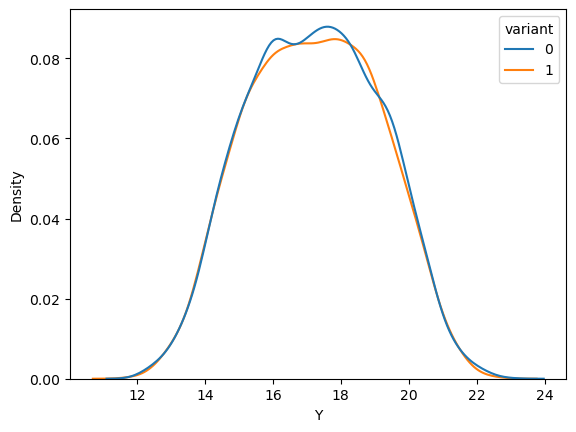

In [77]:
sns.kdeplot(data=cd.data, x=cd.outcomes[0], hue=cd.treatment)

### 1. ATE estimation: Running CausalTune


In [85]:
# CausalTune configuration
num_samples = 10
components_time_budget = 5
train_size = 0.7

target = cd.outcomes[0]

In [86]:
ct = AutoCausality(
    num_samples=num_samples,
    components_time_budget=components_time_budget,
    metric="energy_distance",
    verbose=3,
    components_verbose=3,
    train_size=train_size,
)   
ct.fit(data=cd, outcome=target)

[flaml.tune.tune: 05-16 13:43:54] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 05-16 13:43:54] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.auto_causality.models.NaiveDummy'}}


Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impur

[flaml.tune.tune: 05-16 13:43:54] {198} INFO - result: {'energy_distance': 0.007011752515238889, 'estimator_name': 'backdoor.auto_causality.models.NaiveDummy', 'scores': {'train': {'ate': -0.04208969109980015, 'ate_std': 0.00042308312136897416, 'erupt': 17.227812483605984, 'norm_erupt': 17.22864301778871, 'qini': 4.729713386913961, 'auc': -0.5000773150754506, 'values':       treated          Y         p  policy  norm_policy  weights
0           0  16.443682  0.504143   False         True  2.01671
1           1  19.220052  0.504143   False        False  0.00000
2           1  16.795653  0.504143   False        False  0.00000
3           1  17.168290  0.504143   False        False  0.00000
4           0  17.372071  0.504143   False        False  2.01671
...       ...        ...       ...     ...          ...      ...
6995        0  15.901622  0.504143   False         True  2.01671
6996        0  19.665493  0.504143   False         True  2.01671
6997        1  13.684731  0.504143   False 

Difference in means estimate (naive ATE):

In [80]:
ct.scorer.naive_ate(cd.data[cd.treatment], cd.data[target])[0]

-0.01313951552879189

CausaTune ATE estimate:

In [81]:
ct.effect(ct.test_df).mean()

-0.043028921555375396

### Explainable variation

As a first performance check of this approach we test how much of the variation in the outcome metric remains unexplained with our outcome model prediction approach. 

For this, we use AutoML to predict outcomes as is done under the hood of CausalTune.
The lower the unexplained variation, the more promising it is to use CausalTune for AB Testing.

In [30]:
automl = AutoML()
automl.fit(cd.data[cd.data.columns.drop([target])], cd.data[target], task='regression', time_budget=60)

[flaml.automl: 05-16 09:53:42] {2599} INFO - task = regression
[flaml.automl: 05-16 09:53:42] {2601} INFO - Data split method: uniform
[flaml.automl: 05-16 09:53:42] {2604} INFO - Evaluation method: holdout
[flaml.automl: 05-16 09:53:42] {2726} INFO - Minimizing error metric: 1-r2
[flaml.automl: 05-16 09:53:42] {2870} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 05-16 09:53:42] {3166} INFO - iteration 0, current learner lgbm
[flaml.automl: 05-16 09:53:42] {3296} INFO - Estimated sufficient time budget=341s. Estimated necessary time budget=3s.
[flaml.automl: 05-16 09:53:42] {3343} INFO -  at 0.2s,	estimator lgbm's best error=0.9850,	best estimator lgbm's best error=0.9850
[flaml.automl: 05-16 09:53:42] {3166} INFO - iteration 1, current learner lgbm
[flaml.automl: 05-16 09:53:42] {3343} INFO -  at 0.2s,	estimator lgbm's best error=0.9850,	best estimator lgbm's best error=0.9850
[flaml.automl: 05-16 09:53:4

In [59]:
# Fraction of variation unexplained
mse = mean_squared_error(automl.predict(ct.test_df[ct.test_df.columns.drop([target])]), ct.test_df[target])
var_y = cd.data[target].var()
fvu = mse / var_y
print(f'Variation unexplained: {100*fvu:.2f}%')

Variation unexplained: 32.04%


### Bootstrapping with simple component models for inference


In [62]:
# bootstrap configuration

n_samples = 10
n_sample_size = cd.data.shape[0]

components_time_budget = 1
train_size = .7
num_samples= 1

ct_ate = []
scores = []
naive_ate = []

In [71]:
for _ in range(n_samples):
    cd_bt = generate_synth_data_with_categories()
    cd_bt.preprocess_dataset()
    outcome_regressor = RandomForestRegressor()
    
    ct = AutoCausality(
        num_samples=num_samples,
        components_time_budget=components_time_budget,
        metric="energy_distance",
        train_size=train_size,
        propensity_model='dummy',
        outcome_model=outcome_regressor
        )        

    ct.fit(data=cd, outcome=target)

    ct_ate.append(ct.effect(ct.test_df).mean())
    scores.append(ct.best_score)
    naive_ate.append(ct.scorer.naive_ate(cd_bt.data[cd_bt.treatment], cd_bt.data[target])[0])
    del ct, cd_bt, outcome_regressor
    gc.collect()

[flaml.tune.tune: 05-16 10:15:56] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 05-16 10:15:56] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.auto_causality.models.NaiveDummy'}}


Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impur

[flaml.tune.tune: 05-16 10:15:56] {198} INFO - result: {'energy_distance': 0.006792934398862194, 'estimator_name': 'backdoor.auto_causality.models.NaiveDummy', 'scores': {'train': {'ate': -0.011579309137595114, 'ate_std': 0.000116246964705089, 'erupt': 18.55996201162422, 'norm_erupt': 18.553505788081747, 'qini': -23.852848985673297, 'auc': -1.399911751519962, 'values':       treated          Y         p  policy  norm_policy   weights
0           1  16.637389  0.493286   False         True  0.000000
1           0  15.619788  0.493286   False        False  1.973499
2           1  17.450365  0.493286   False         True  0.000000
3           0  18.552339  0.493286   False         True  1.973499
4           0  15.800541  0.493286   False        False  1.973499
...       ...        ...       ...     ...          ...       ...
6995        0  19.256347  0.493286   False        False  1.973499
6996        1  19.757813  0.493286   False         True  0.000000
6997        0  20.691722  0.493286

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impur

[flaml.tune.tune: 05-16 10:15:56] {198} INFO - result: {'energy_distance': 0.005983301187777457, 'estimator_name': 'backdoor.auto_causality.models.NaiveDummy', 'scores': {'train': {'ate': -0.0391809242264879, 'ate_std': 0.0003876940874276623, 'erupt': 18.606178353553545, 'norm_erupt': 18.6014193548534, 'qini': 21.25206294864325, 'auc': -0.3767425906132473, 'values':       treated          Y         p  policy  norm_policy   weights
0           1  20.112318  0.497571   False        False  0.000000
1           0  20.647893  0.497571   False        False  1.990333
2           1  21.043673  0.497571   False        False  0.000000
3           0  19.812145  0.497571   False         True  1.990333
4           1  19.577449  0.497571   False        False  0.000000
...       ...        ...       ...     ...          ...       ...
6995        1  18.395654  0.497571   False        False  0.000000
6996        1  20.879923  0.497571   False        False  0.000000
6997        0  20.293234  0.497571   

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impur

[flaml.tune.tune: 05-16 10:15:57] {198} INFO - result: {'energy_distance': 0.008223708603578572, 'estimator_name': 'backdoor.auto_causality.models.NaiveDummy', 'scores': {'train': {'ate': -0.053330272370589064, 'ate_std': 0.0005328490124000781, 'erupt': 18.58544796784066, 'norm_erupt': 18.58999439386208, 'qini': 52.47089325100652, 'auc': -0.22797989638940153, 'values':       treated          Y         p  policy  norm_policy   weights
0           0  16.048306  0.504429   False        False  2.017873
1           1  15.791355  0.504429   False        False  0.000000
2           0  22.121083  0.504429   False         True  2.017873
3           1  17.616941  0.504429   False         True  0.000000
4           1  21.248339  0.504429   False        False  0.000000
...       ...        ...       ...     ...          ...       ...
6995        0  20.719193  0.504429   False        False  2.017873
6996        1  21.751761  0.504429   False        False  0.000000
6997        0  21.770173  0.504429

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impur

[flaml.tune.tune: 05-16 10:15:57] {198} INFO - result: {'energy_distance': 0.0058109873680871615, 'estimator_name': 'backdoor.auto_causality.models.NaiveDummy', 'scores': {'train': {'ate': -0.05969376352754612, 'ate_std': 0.0005969679158480774, 'erupt': 18.599203079643647, 'norm_erupt': 18.546238341526777, 'qini': -108.2984456472235, 'auc': -1.0286201663954293, 'values':       treated          Y      p  policy  norm_policy   weights
0           0  17.528751  0.503   False         True  2.012072
1           0  20.194275  0.503   False        False  2.012072
2           1  17.681854  0.503   False         True  0.000000
3           1  20.532287  0.503   False        False  0.000000
4           1  22.146098  0.503   False        False  0.000000
...       ...        ...    ...     ...          ...       ...
6995        1  19.226113  0.503   False         True  0.000000
6996        0  16.062745  0.503   False         True  2.012072
6997        1  17.474206  0.503   False        False  0.000

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impur

[flaml.tune.tune: 05-16 10:15:58] {198} INFO - result: {'energy_distance': 0.005788010381093223, 'estimator_name': 'backdoor.auto_causality.models.NaiveDummy', 'scores': {'train': {'ate': -0.05035427163124883, 'ate_std': 0.0005012833328496887, 'erupt': 18.572021588395803, 'norm_erupt': 18.604408988210302, 'qini': 77.59782902824692, 'auc': -0.15252976465491122, 'values':       treated          Y      p  policy  norm_policy   weights
0           0  16.015486  0.501   False         True  2.004008
1           0  20.925857  0.501   False        False  2.004008
2           1  20.566342  0.501   False         True  0.000000
3           1  16.008869  0.501   False        False  0.000000
4           0  16.292683  0.501   False        False  2.004008
...       ...        ...    ...     ...          ...       ...
6995        1  16.503242  0.501   False        False  0.000000
6996        0  21.124333  0.501   False        False  2.004008
6997        1  19.519575  0.501   False         True  0.0000

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impur

[flaml.tune.tune: 05-16 10:15:58] {198} INFO - result: {'energy_distance': 0.005135261588912421, 'estimator_name': 'backdoor.auto_causality.models.NaiveDummy', 'scores': {'train': {'ate': 0.001947649643368465, 'ate_std': 1.9312691509662422e-05, 'erupt': 18.573675278887926, 'norm_erupt': 18.61171622669532, 'qini': 68.03274416428596, 'auc': 12.535443754348988, 'values':       treated          Y         p  policy  norm_policy   weights
0           0  18.297895  0.505286    True         True  0.000000
1           1  20.455774  0.505286    True         True  1.979078
2           0  16.926579  0.505286    True        False  0.000000
3           1  18.110362  0.505286    True        False  1.979078
4           0  21.282630  0.505286    True         True  0.000000
...       ...        ...       ...     ...          ...       ...
6995        1  19.883264  0.505286    True         True  1.979078
6996        1  21.166955  0.505286    True        False  1.979078
6997        1  21.949851  0.505286 

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impur

[flaml.tune.tune: 05-16 10:15:59] {198} INFO - result: {'energy_distance': 0.007758453705789314, 'estimator_name': 'backdoor.auto_causality.models.NaiveDummy', 'scores': {'train': {'ate': 0.004967161314645033, 'ate_std': 4.955200090092801e-05, 'erupt': 18.531350579393045, 'norm_erupt': 18.51556313105187, 'qini': -24.609333787208605, 'auc': -1.2673392952490135, 'values':       treated          Y         p  policy  norm_policy   weights
0           0  18.829940  0.504429    True         True  0.000000
1           0  15.457717  0.504429    True        False  0.000000
2           0  18.079474  0.504429    True         True  0.000000
3           0  21.252543  0.504429    True         True  0.000000
4           0  19.867758  0.504429    True        False  0.000000
...       ...        ...       ...     ...          ...       ...
6995        0  18.956735  0.504429    True        False  0.000000
6996        1  15.425403  0.504429    True         True  1.982441
6997        0  16.427027  0.50442

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impur

[flaml.tune.tune: 05-16 10:15:59] {198} INFO - result: {'energy_distance': 0.0052745134072340605, 'estimator_name': 'backdoor.auto_causality.models.NaiveDummy', 'scores': {'train': {'ate': -0.050069357732443864, 'ate_std': 0.0005002133916783034, 'erupt': 18.591171986206607, 'norm_erupt': 18.62312517475528, 'qini': 41.280741448026525, 'auc': -0.2818577034783602, 'values':       treated          Y         p  policy  norm_policy   weights
0           0  19.281053  0.503143   False        False  2.012651
1           1  20.242997  0.503143   False        False  0.000000
2           0  21.141306  0.503143   False        False  2.012651
3           1  20.316544  0.503143   False         True  0.000000
4           0  22.001497  0.503143   False        False  2.012651
...       ...        ...       ...     ...          ...       ...
6995        0  17.719065  0.503143   False        False  2.012651
6996        1  16.700631  0.503143   False        False  0.000000
6997        0  21.009746  0.5031

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impur

[flaml.tune.tune: 05-16 10:16:00] {198} INFO - result: {'energy_distance': 0.006610284194676019, 'estimator_name': 'backdoor.auto_causality.models.NaiveDummy', 'scores': {'train': {'ate': -0.0695606086181253, 'ate_std': 0.0006930908799010237, 'erupt': 18.60165880080607, 'norm_erupt': 18.59702044598442, 'qini': -34.9238439868696, 'auc': -0.537915893962846, 'values':       treated          Y         p  policy  norm_policy   weights
0           0  20.110090  0.501143   False         True  2.004582
1           1  15.638357  0.501143   False         True  0.000000
2           0  17.043327  0.501143   False        False  2.004582
3           1  20.833821  0.501143   False        False  0.000000
4           1  15.928459  0.501143   False        False  0.000000
...       ...        ...       ...     ...          ...       ...
6995        0  18.135049  0.501143   False         True  2.004582
6996        0  19.740795  0.501143   False         True  2.004582
6997        0  17.065648  0.501143   F

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impur

[flaml.tune.tune: 05-16 10:16:00] {198} INFO - result: {'energy_distance': 0.006714130112385419, 'estimator_name': 'backdoor.auto_causality.models.NaiveDummy', 'scores': {'train': {'ate': -0.07526288357717965, 'ate_std': 0.0007495062427130468, 'erupt': 18.618508971518978, 'norm_erupt': 18.609667111898535, 'qini': 12.368160265707115, 'auc': -0.5063336932090177, 'values':       treated          Y         p  policy  norm_policy   weights
0           0  21.522560  0.500143   False         True  2.000572
1           1  17.148742  0.500143   False        False  0.000000
2           0  20.946794  0.500143   False        False  2.000572
3           1  17.023447  0.500143   False        False  0.000000
4           0  18.395886  0.500143   False         True  2.000572
...       ...        ...       ...     ...          ...       ...
6995        1  20.000841  0.500143   False        False  0.000000
6996        0  16.446436  0.500143   False         True  2.000572
6997        1  16.157334  0.50014

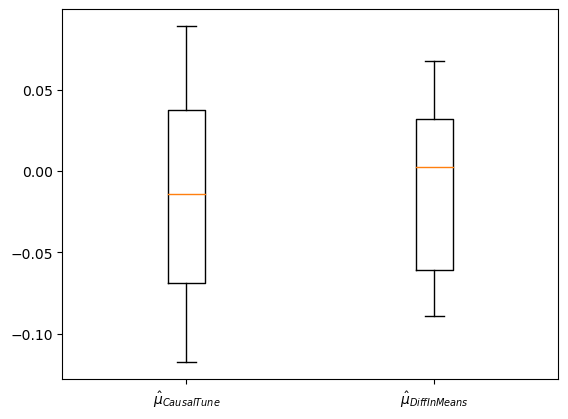

In [72]:
fig, ax = plt.subplots()

ax.boxplot([ct_ate, naive_ate])
ax.set_xticklabels(['$\hat{\mu}_{CausalTune}$', '$\hat{\mu}_{DiffInMeans}$'])
plt.show()

### 2. Segmentation with Wise Pizza

In [51]:
segments = list(set(cd.data.columns) - set([cd.treatment]) - set(cd.outcomes) - set(['random']))

ps_counts = (
    cd.data#.loc[cd.data[cd.treatment].isin([0, cd.treatment]), :]
    .groupby(by=segments)[cd.treatment]
    .agg("count")
)

df_effects = pd.concat([cd.data[segments], pd.Series(ct.effect(cd.data), name='CATE')], axis=1)
df_eff_by_seg = df_effects.groupby(by=segments)['CATE'].agg('mean')

df_wp = pd.concat([df_eff_by_seg, ps_counts], axis=1).reset_index()
df_wp['totals'] = df_wp['variant'] * df_wp['CATE']

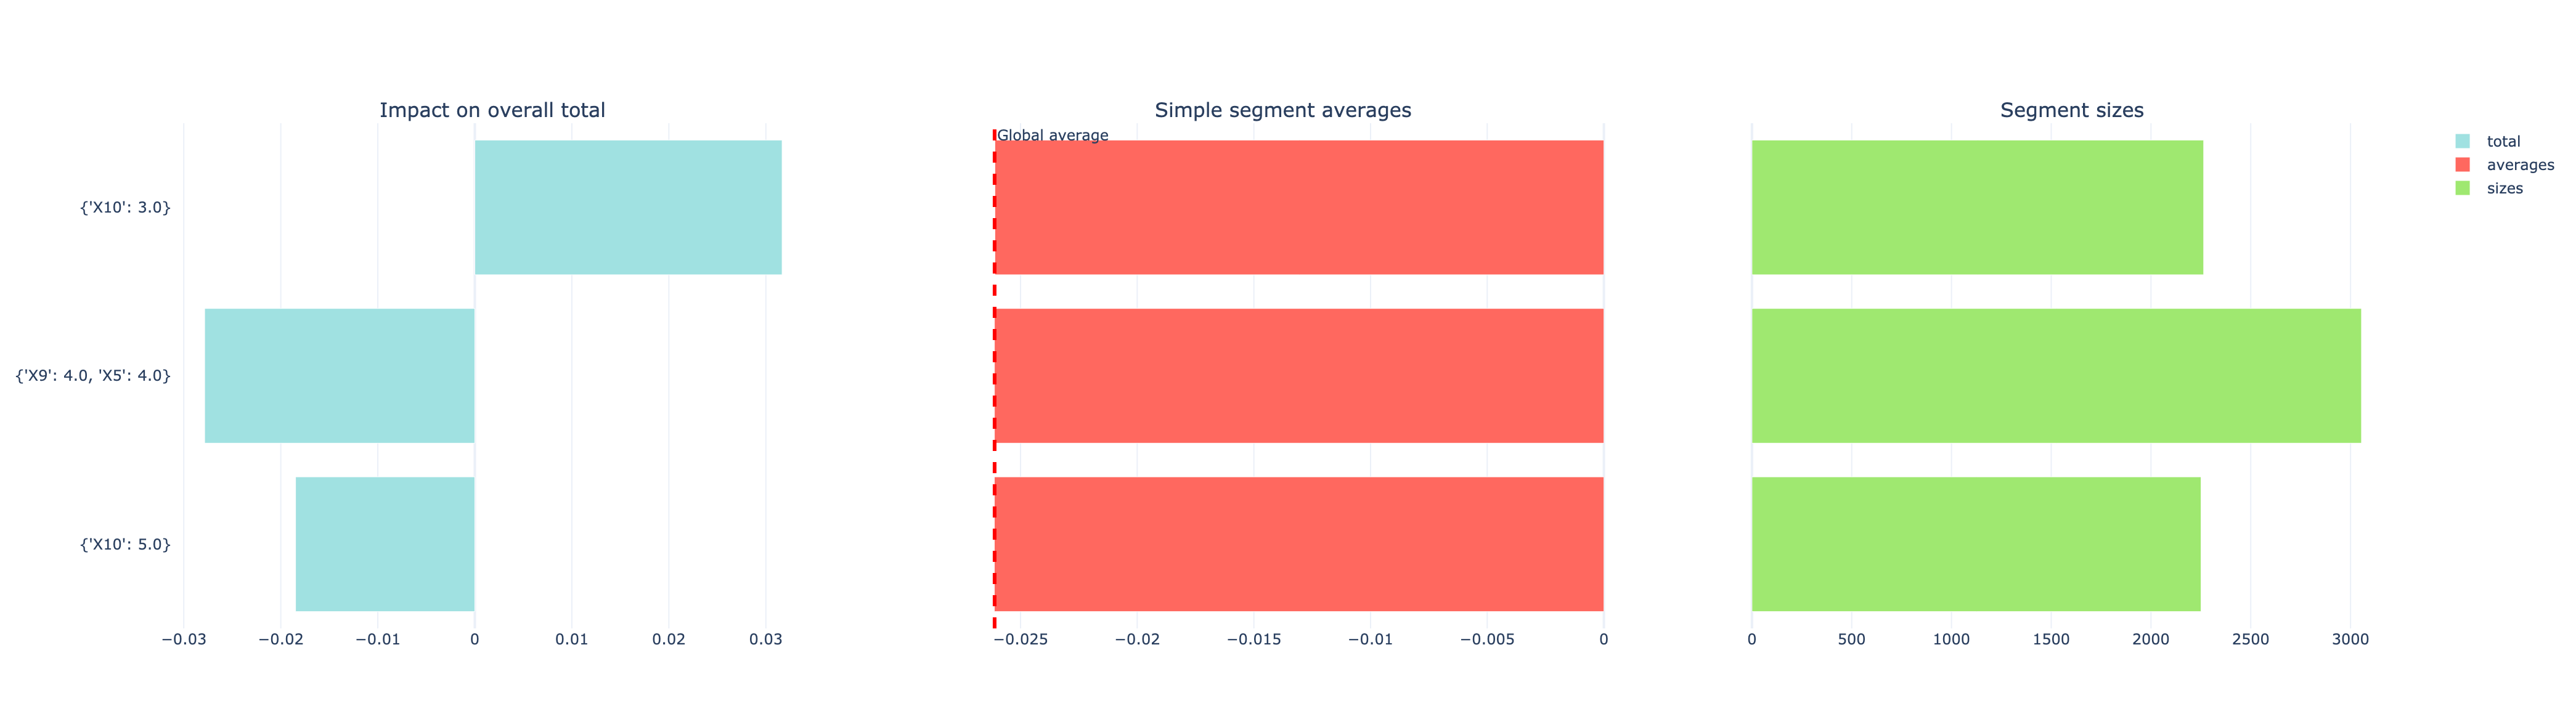

In [54]:
max_depth = 2
min_segments = 3

sf = wp.explain_levels(
    df=df_wp,
    dims=segments,
    total_name='totals',
    size_name=cd.treatment,
    max_depth=max_depth,
    min_segments=min_segments,
)
sf.plot()